### Installing Qiskit

In [ ]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 20.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
!nvidia-smi

Thu Jun 13 17:41:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Libraries Importing


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from math import log2
from sympy import *
import json, time, os

simulation_time = time.time() # to calculate simulation time
init_printing()

In [4]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())
# backend.set_options(device="GPU")

('CPU',)


In [ ]:
# services = []

# for i in range(1,5):
#     services.append(QiskitRuntimeService(channel="ibm_quantum", token=os.getenv(f"TOKEN{i}")))

# backend = service.backend("ibm_osaka") # for real quantum
# backend = service.backend("ibm_kyoto") # for real quantum


### Problem definition

In [5]:
conf = json.load(open("conf_v3.json","r"))

In [6]:
C = conf["C"] # n
S = conf["S"] # m
P = conf["P"]
K = conf["K"]

L = int(log2(C)+1)

random_seed = conf["random_seed"]
shots = conf["shots"] * 10
layers = conf["layers"]

iterations = 0

required_qubits = S * C + (S + 1) * L # l is log C

print("Requried Qubits: ", required_qubits)

Requried Qubits:  10


In [7]:
equations = []

### Formulation

#### Equations

In [8]:
for j in range(1, S + 1):
  equation = 0

  for i in range(1, C + 1):
    equation += symbols(f"x_{i}{j}") * P[i-1][j-1]

  for h in range(L):
    q1 = symbols(f"z_{h}")*2**h
    q2 = symbols(f"τ_{j}{h}")*2**h

    equation += (q2 - q1)

  equation = equation**2
  equation = equation.expand()
  equations.append(equation)

print(equations)

[x_21**2 - 2*x_21*z_0 - 4*x_21*z_1 + 2*x_21*τ_10 + 4*x_21*τ_11 + z_0**2 + 4*z_0*z_1 - 2*z_0*τ_10 - 4*z_0*τ_11 + 4*z_1**2 - 4*z_1*τ_10 - 8*z_1*τ_11 + τ_10**2 + 4*τ_10*τ_11 + 4*τ_11**2, x_12**2 + 2*x_12*x_22 - 2*x_12*z_0 - 4*x_12*z_1 + 2*x_12*τ_20 + 4*x_12*τ_21 + x_22**2 - 2*x_22*z_0 - 4*x_22*z_1 + 2*x_22*τ_20 + 4*x_22*τ_21 + z_0**2 + 4*z_0*z_1 - 2*z_0*τ_20 - 4*z_0*τ_21 + 4*z_1**2 - 4*z_1*τ_20 - 8*z_1*τ_21 + τ_20**2 + 4*τ_20*τ_21 + 4*τ_21**2]


#### Decodeing Equations

In [9]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0])
  temp = [theta, decode(terms)]

  if(int(theta) == 4 and len(temp[1])==2 and temp[1][0] == temp[1][1]):
    print(terms)

  return [theta, decode(terms)]

def decode(terms):
  output = []
  for term in terms:

    term = str(term)
    if term.startswith("z"):
      h = int(term[2])
      output.append(h)


    elif term.startswith("τ"):
      j = int(term[2])
      h = int(term[3])
      output.append(j * L + h)

    elif term.startswith("x"):
      i = int(term[2])
      j = int(term[3])
      temp = (S + 1) * (L - 1)
      output.append(temp + (((i-1) * S) + j))


  return output

#### Other Registes

In [11]:
prepared_equations = []
for equation in equations:
  temp = []
  for term in args(equation):
    if len(term.args) != 0:
      temp.append(prepare_equation(term))
  prepared_equations.append(temp)
prepared_equations


[x_12, τ_21]


### Implementation

#### Objective Function

In [ ]:
def objective(bit_string):
  bit_string = bit_string[::-1] # since qiskit represent solution in least significant bit format
  cost = 0
  a = b = 0

  # equation a
  for h in range(L):
    cost += 2**h * int(bit_string[h])
  if cost > C:
    cost += (cost - C) *  K

  # equation b
  for j in range(1, S + 1):
    temp_cost = 0

    for i in range(1, C + 1):
      temp = (S + 1) * (L - 1)
      temp_cost += int(bit_string[temp + (((i-1) * S) + j)])

    for h in range(L):
      temp = (S + 1) * (L - 1)
      q1 = int(bit_string[h]) * 2**h
      q2 = int(bit_string[temp + (((i-1) * S) + j)]) * 2**h

      temp_cost += (q2 - q1)
    cost += temp_cost**2

  return [cost, a, b]

In [ ]:
objective("00000000000001000")

[0, 0, 0]

#### Circuit

In [ ]:
def layers_gen(p, initial_value = 1.0):
  return [initial_value] * p * 2

def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits):
      qc.h(i)

    # S0
    for i in range(L):
      theta = 2**i * -0.5
      qc.rz(theta,i)

    for layer_index in range(n_layers):
        for equation in prepared_equations:
          for term in equation:
            theta = int(term[0])
            locations = term[1]

            if len(locations) == 1: # i.e. trivial term
                qc.rz(theta * 0.5 * alpha[layer_index], locations[0])

            elif len(locations) == 2:
                qc.rz(theta * -0.25 * alpha[layer_index], locations[0]) # -1/4 * z1 = -1/4 * z1
                qc.rz(theta * -0.25 * alpha[layer_index], locations[1]) # -1/4 * z2 = -1/4 * z2
                # if(term != [8, [8, 8]]):
                print(term)
                qc.rzz(theta * 0.25 * alpha[layer_index], locations[0], locations[1]) # -1/4 * -z1z2 = 1/4 * z1z2

        # for qubit in range(required_qubits - 1):
        #     qc.rx(2 * gamma[layer_index] , qubit)

        # try with 2* and without

        # even
        temp = -1
        for i in range(1, required_qubits, 2):
            if(temp!= -1):
              qc.cx(temp,i)
              qc.rx(gamma[layer_index],temp)
              qc.ry(gamma[layer_index],temp)
              qc.cx(temp,i)
            temp = i

        # odd
        temp = -1
        for i in range(0, required_qubits, 2):
            if(temp!= -1):
              qc.cx(temp,i)
              qc.rx(gamma[layer_index],temp)
              qc.ry(gamma[layer_index],temp)
              qc.cx(temp,i)
            temp = i

        # first last
        qc.cx(0,required_qubits-1)
        qc.rx(0,required_qubits-1)
        qc.ry(0,required_qubits-1)
        qc.cx(0,required_qubits-1)

    qc.measure_all()
    print(thetas)

    return qc

In [ ]:
total = [0] * 2
def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj, a, b = objective(bit_string)
        total[0] += a
        total[1] += b
        avg += obj * count
        sum_count += count
    return avg/sum_count

def get_expectation():

    def execute_circ(theta):
        global iterations
        qc = create_qaoa_circ(theta)
        tc = transpile(qc,backend,optimization_level=3,seed_transpiler=random_seed)

        counts = backend.run(tc, seed_simulator=random_seed, shots=shots).result().get_counts()
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [ ]:
from scipy.optimize import minimize,differential_evolution
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA')
minimization_time = time.time() - start_time

res

[-8, [1, 3]]
[-4, [6, 1]]
[-4, [0, 3]]
[-4, [1, 2]]
[-2, [6, 0]]
[-2, [0, 2]]
[2, [6, 2]]
[4, [6, 3]]
[4, [0, 1]]
[4, [2, 3]]
[-8, [1, 5]]
[-4, [5, 1]]
[-4, [0, 5]]
[-4, [1, 4]]
[-2, [5, 0]]
[-2, [0, 4]]
[2, [5, 4]]
[4, [5, 5]]


CircuitError: 'duplicate qubit arguments'

In [ ]:
print("a:",total[0])
print("b:",total[1])

a: 0
b: 0


### Results

[0.71510001 1.06224233 0.62442471 2.05235296 0.86234611 0.79523559
 0.43252652 0.28842841 0.7939431  0.65592898]
9484
-----------------
BINGO
01000000000011000
1
-----------------
-----------------
BINGO
10000000001101000
1
-----------------
-----------------
BINGO
01000000000101000
1
-----------------
-----------------
BINGO
01000000000001000
1
-----------------
-----------------
BINGO
00000000000001000
1
-----------------
Solution 00101001100111111 cost: 3052 count 4
Solution 11010000001101011 cost: 37 count 4
Solution 10010110111010001 cost: 83 count 4
Solution 10000011110010101 cost: 1023 count 4
Solution 01101100001111101 cost: 1037 count 4
Solution 10101101100111001 cost: 83 count 3
Solution 11001100000101011 cost: 11 count 3
Solution 10001100010100100 cost: 17 count 3
Solution 11110010011011101 cost: 1037 count 3
Solution 01001000000111001 cost: 2 count 3


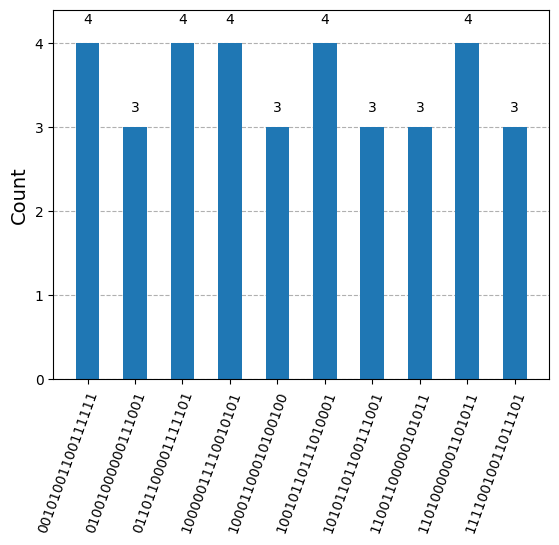

In [ ]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
counts = backend.run(qc_res, seed_simulator=random_seed, shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
counts_cost = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
  if objective(key)[0] == 0:
    print("-----------------")
    print("BINGO")
    print(key)
    print(counts[key])
    print("-----------------")

for key in binary[:10]:
    print("Solution",key ,"cost:",objective(key)[0],"count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [ ]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["C"] = C
counts["P"] = P
counts["S"] = S
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

In [ ]:
file = open(f"./{C}_{S}_{shots}_{layers}_{time.time_ns()}.json", "w")
file.write(json.dumps(counts))
file.flush()

In [ ]:
counts["execution_time"]

In [ ]:
minimization_time